In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import svd, eig
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds, eigs

In [1]:
import re
file = open("test.txt", "r")

doclist = [line for line in file]    
docstr = ''.join(doclist)
sentences = re.split(r'[.!?]', docstr)
sentences = [sentence.split() for sentence in sentences if len(sentence) > 1]

In [2]:
files = open('enwik9.txt','r').read().split('Splitting Text')
names=['file1','file2','file3']
for num,file in enumerate(files):
    open(names[num],'w').write(file)

In [3]:
def create_vocabulary(sentences, d=200): #пусть пока будет 200, чтобы сравнивать с дз
    vocabulary = {}
    wordfreq = {}
    for sentence in sentences:
        for word in sentence:
            if word not in wordfreq:
                wordfreq[word] = 0 
            wordfreq[word] += 1
    i = 0
    for word in wordfreq:
        if wordfreq[word] > d:
            vocabulary[word] = i
            i += 1
    return vocabulary

In [4]:
vocabulary = create_vocabulary(sentences)

In [5]:
def create_corpus_matrix(sentences, vocabulary):
    n = len(vocabulary)
    corpus_matrix = np.zeros((n, n))
    
    for sentense in sentences:
        for position_of_word in range(len(sentense)):
            for i in range(max(0, position_of_word - 2), min(position_of_word + 3, len(sentense))):
                word = sentense[position_of_word]
                context = sentense[i]
                if (word in vocabulary and context in vocabulary) == True and i != position_of_word:
                    corpus_matrix[vocabulary[word]][vocabulary[context]] += 1
                
    return corpus_matrix

In [6]:
D = create_corpus_matrix(sentences, vocabulary)


In [7]:
def ppmi(D, k=5): #k тоже, как в дз. Они в статье тоже 5 выбирали
    M = np.zeros(D.shape)
    n = np.sum(D)
    w = np.sum(D, axis = 0)
    c = np.sum(D, axis = 1)
    for i in range(len(D)):
        for j in range(len(D[i])):
            if n * D[i][j]/(w[i] * c[j] * k) == 0:
                M[i][j] = 0
            else:
                M[i][j] = max(0, np.log(n * D[i][j]/(w[i] * c[j] * k)))
    return M

In [9]:
#%%timeit -r 1 1 
M = ppmi(D)

/home/rumata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/rumata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


1min 32s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
#Не использовал, так у меня фэйлил комп, пришлось делать через sparse
def truncated_svd(M, d=200):
    u, s, v = np.linalg.svd(M)
    u_d = u[:, :d]
    s_d = s[:d]
    v_d = v[:d, :]
    M_ppmi = (u_d.dot(np.diag(s_d))).dot(v_d)
    return M_ppmi

def embedding_matrix(M, d=200):
    u, s, v = np.linalg.svd(M)
    W_svd = u[:, :d]
    return W_svd

In [17]:
#кусок со sparse
M_sparse = scipy.sparse.csr_matrix(M)

In [30]:
def truncated_svd_1(M, d=200):
    u, s, v = svds(M, k=200)
    u_d = u[:, :d]
    s_d = s[:d]
    v_d = v[:d, :]
    M_ppmi = (u_d.dot(np.diag(s_d))).dot(v_d)
    return M_ppmi

In [31]:
truncM = truncated_svd_1(M_sparse)

(7694, 200) (200,)
8888888
(7694, 200)
(7694, 7694)


In [23]:
#%%timeit -r 1 1 
def embedding_matrix_1(M, d=200):
    u, s, v = svds(M, k = d)
    W_svd = u[:, :d]
    return W_svd

cutM = embedding_matrix_1(truncM)

In [ ]:
#не запускал
#import sklearn
#from sklearn.decomposition import TruncatedSVD
#svd = TruncatedSVD(n_components=200, algorithm=’randomized’, n_iter=2)
#svd.fit(M)

## Word2vec

In [53]:
import gensim

In [69]:
model = gensim.models.Word2Vec(sentences, min_count=200)

In [70]:
model.wv.vectors.shape

(7722, 100)

In [ ]:
eig_val_w2v, eig_vec_w2v = np.linalg.eig()

## Eigenvectors distibution

In [ ]:
# SVD PPMI
eig_val, eig_vec = np.linalg.eig(M)

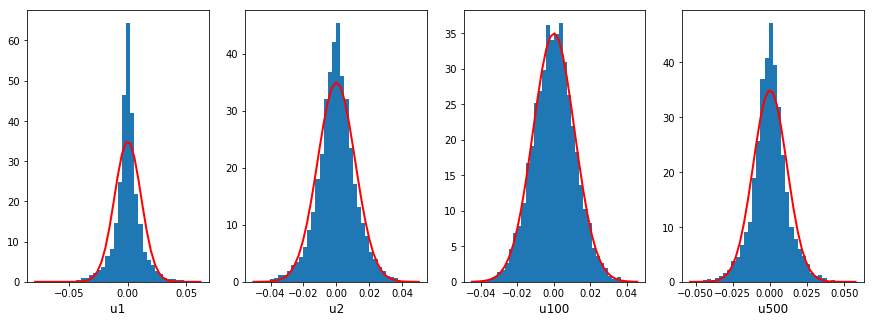

In [46]:
#eigenvectors listlist
eig_list = [eig_vec[1], eig_vec[2], eig_vec[100], eig_vec[200]]
eig_list_names = ['u1', 'u2', 'u100', 'u500']
plt.figure(figsize=(15,5))

for i, eig in enumerate(eig_list):
    a = eig 
    mu = np.mean(a)
    sigma = np.std(a)
    
    plt.subplot(1, 4, i+1)
    count, bins, ignored = plt.hist(a, 40, density = True)
    plt.plot(bins, 1/(sigma*(np.sqrt(2 * np.pi))) * np.exp(- (bins-mu)**2 /(2*sigma**2) ), linewidth=2, color='r')
    plt.xlabel('%s'% eig_list_names[i], fontsize=12)
    
#plt.title('Eigenvectors distribution')    
plt.show()



## Inverse Participation Ratio (IPR)

In [52]:
IPR = [sum(eig**4) for eig in eig_vec]

0.0028328611898017